In [42]:
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helper_functions as hf
from constants import KAGGLE_DIR, GENERATED_DIR, CURRENT_YR

## Add some team spellings to MTeamSpellings.csv manually

In [15]:
team_spellings = pd.read_csv(f'{KAGGLE_DIR}/MTeamSpellings.csv', encoding='unicode_escape')

In [16]:
unmatched_spellings_lst = [('miami', 1274)]
unmatched_spellings = pd.DataFrame({
    'TeamNameSpelling': [spelling for spelling, _ in unmatched_spellings_lst],
    'TeamID': [teamid for _, teamid in unmatched_spellings_lst]
})
unmatched_spellings

,TeamNameSpelling,TeamID
0,miami,1274


In [17]:
full_spellings = pd.concat([team_spellings, unmatched_spellings], ignore_index=True)
full_spellings.drop_duplicates(inplace=True)
full_spellings.to_csv(f'{KAGGLE_DIR}/MTeamSpellings.csv', index=False)

In [18]:
link = 'https://www.espn.com/mens-college-basketball/rankings/_/week/1/year/'+str(CURRENT_YR)+'/seasontype/2'

In [27]:
def get_preseason_rankings(yr):
    link = 'https://www.espn.com/mens-college-basketball/rankings/_/week/1/year/'+str(yr)+'/seasontype/2'
    with urllib.request.urlopen(link) as url:
        page = url.read()
    soup = BeautifulSoup(page, "html.parser")
    rk_table = soup.find('table', {'class':'Table'})
    trs = rk_table.find_all('tr')
    cols = ['Season','school','preseason_pts']
    preseason_rk_df = pd.DataFrame(columns=cols)
    for tr in trs[1:]:
        tds = tr.find_all('td')
        pts = int(tds[3].text)
        team = tds[1].find('div').find('span').find('a').find('img').get('title').lower()
        new_row = pd.DataFrame(columns=cols)
        new_row.loc[0] = [yr, team, pts]
        preseason_rk_df = pd.concat([preseason_rk_df, new_row], ignore_index=True)
    votes_text = soup.find('p', {'class':'TableDetails__Paragraph'}).text
    team_votes_str_lst = votes_text.split(':')[1].split(',')
    for team_vote_str in team_votes_str_lst:
        team_vote_lst = team_vote_str.split(' ')
        pts = int(team_vote_lst[len(team_vote_lst)-1])
        team = ' '.join(team_vote_lst[:len(team_vote_lst)-1]).lower().strip()
        new_row = pd.DataFrame(columns=cols)
        new_row.loc[0] = [yr, team, pts]
        preseason_rk_df = pd.concat([preseason_rk_df, new_row], ignore_index=True)
    return(preseason_rk_df)

In [28]:
def preseason_join_to_team(preseason_rk_df):
    team_spellings = pd.read_csv(f'{KAGGLE_DIR}/MTeamSpellings.csv', encoding='unicode_escape')
    preseason_joined = team_spellings.merge(preseason_rk_df, left_on='TeamNameSpelling', right_on='school')
    #preseason_joined.drop('TeamNameSpelling', axis=1, inplace=True)
    return(preseason_joined)

In [29]:
def check_for_missing_spellings(df, joined):
    comp = df.merge(joined, on='school', how='left')
    return(comp[comp['TeamNameSpelling'].isna()])

In [30]:
preseason_rankings = get_preseason_rankings(2003)
preseason_joined = preseason_join_to_team(preseason_rankings)
for yr in range(2004,CURRENT_YR+1):
    #print(yr)
    new_preseason_rankings = get_preseason_rankings(yr)
    new_preseason_joined = preseason_join_to_team(new_preseason_rankings)
    preseason_joined = pd.concat([preseason_joined, new_preseason_joined], ignore_index=True)
    #print(check_for_missing_spellings(new_preseason_rankings, new_preseason_joined))
preseason_joined.drop('TeamNameSpelling', axis=1, inplace=True)

In [35]:
preseason_joined[preseason_joined['Season'] == 2023].sort_values('preseason_pts', ascending=False).reset_index(drop=True)

,TeamID,Season,school,preseason_pts
0,1314,2023,north carolina,1532
1,1211,2023,gonzaga,1479
2,1222,2023,houston,1404
3,1246,2023,kentucky,1364
4,1242,2023,kansas,1200
5,1124,2023,baylor,1200
6,1181,2023,duke,1168
7,1417,2023,ucla,1093
8,1166,2023,creighton,1060
9,1116,2023,arkansas,1026


In [38]:
preseason_rk_yr

,Season,school,preseason_pts


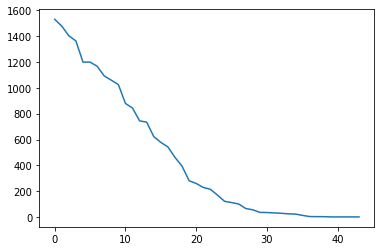

In [40]:
preseason_rk_yr = preseason_joined[preseason_joined['Season'] == 2023].sort_values('preseason_pts', ascending=False).reset_index(drop=True)
plt.plot(preseason_rk_yr.index, preseason_rk_yr['preseason_pts'])
plt.show()

In [43]:
preseason_joined.to_csv(f'{GENERATED_DIR}/preseason_rankings.csv', index=False)